# Writing High-Frequency Trajectories When an Event is Detected

In this tutorial, we will showcase how Dupin's online capabilities can be used to
trigger HOOMD's burst writer to dump high-resolution trajectory data only during
specific events detected by Dupin. This approach has significant implications for
performance and storage. The main advantage is that it allows us to write to disk only
the segments of the trajectory that are of interest, at an extremely high frequency,
without dumping the entire trajectory.

To achieve this, we create a temporary buffer that stores trajectory frames in memory.
When Dupin triggers, this buffer is dumped onto the disk. Online detection requires some
CPU cycles to run periodically, which can impact performance of the MD program depending
on the order parameters used for detection. In practice, it is often sufficient to track
very simple properties that are computed by the MD driver (in this case, HOOMD) anyway,
such as pressure, total system energy, or volume (depending on whether we are running
NVT/NVE or NPT ensembles).

Here, we provide an example. First we melt a simple cubic crystal of Lennard-Jones
particles:

In [1]:
import math

import fresnel
import IPython
import numpy as np

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)


def render(snapshot):
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=snapshot.particles.N, radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]),
        roughness=0.5,
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(
            direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi
        ),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2),
        look_at=(0, 0, 0),
        up=(0, 1, 0),
        height=L * 1.4 + 1,
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(
        tracer.sample(scene, samples=2500)._repr_png_()
    )

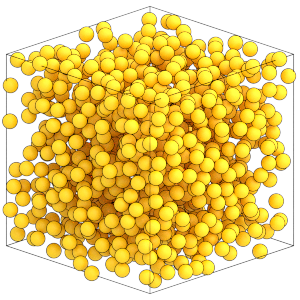

In [2]:
import hoomd
from hoomd import md

# Initialize HOOMD
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
snapshot = hoomd.Snapshot(cpu.communicator)

# Create a simple cubic configuration of particles
N = 10  # particles per box direction
box_l = 13  # box dimension

kt = 10.5

snapshot.configuration.box = [box_l] * 3 + [0, 0, 0]
snapshot.particles.N = N**3
x, y, z = np.meshgrid(
    *(np.linspace(-box_l / 2, box_l / 2, N, endpoint=False),) * 3
)
positions = np.array((x.ravel(), y.ravel(), z.ravel())).T
snapshot.particles.position[:] = positions
snapshot.particles.types = ["A"]
snapshot.particles.typeid[:] = 0

simulation.create_state_from_snapshot(snapshot)

integrator = md.Integrator(dt=0.005)
cell = md.nlist.Cell(buffer=0.4)
lj = md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5
integrator.forces.append(lj)
nvt = md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=md.methods.thermostats.Bussi(kT=kt),
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator

# Thermalize particle momenta
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kt)
simulation.run(0)

# Melt the crystal
simulation.run(10000)  # Increase the number of steps if necessary
hoomd.write.GSD.write(state=simulation.state, filename="random.gsd", mode="wb")
render(simulation.state.get_snapshot())

# Compress the system

Lennard-Jones system crystallizes at densities around 1.05 and temperatures below 1 kT.
We thus compress the system to target density:

/home/domi/mambaforge/envs/dupin/lib/python3.12/site-packages/hoomd/update/box_resize.py:147: FutureWarning: box1, box2, and variant are deprecated, use `box`
  warnings.warn('box1, box2, and variant are deprecated, use `box`',
*Warning*: Simulation.seed is not set, using default seed=0


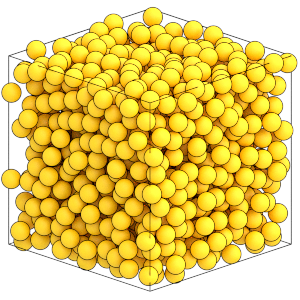

In [3]:
# compress the system
import hoomd
from hoomd import md

cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu)
simulation.create_state_from_gsd("random.gsd")

kt = 1.15
current_rho = simulation.state.N_particles / simulation.state.box.volume
target_rho = 1.05
initial_box = simulation.state.box
final_box = hoomd.Box.from_box(initial_box)
final_box.volume = simulation.state.N_particles / target_rho
integrator = md.Integrator(dt=0.005)
cell = md.nlist.Cell(buffer=0.4)
lj = md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5
integrator.forces.append(lj)
nvt = md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=md.methods.thermostats.Bussi(kT=kt),
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator

ramp = hoomd.variant.Ramp(
    current_rho, target_rho, t_start=simulation.timestep + 5000, t_ramp=25000
)
box_resize_trigger = hoomd.trigger.Periodic(10)
box_resize = hoomd.update.BoxResize(
    initial_box=initial_box,
    final_box=final_box,
    variant=ramp,
    trigger=box_resize_trigger,
)
simulation.operations.updaters.append(box_resize)

simulation.run(35000)
hoomd.write.GSD.write(
    state=simulation.state, filename="compressed.gsd", mode="wb"
)

render(simulation.state.get_snapshot())

# Burst writer

Finally, we run the compressed LJ system at temperature of 0.8 kT and wait for it to
nucleate. We implement a custom Online Writer which dumps 2000 frames space 10 time
steps apart each time dupin detects a transition. Each event will be written in a new
file starting with burst and ending with .gsd . We monitor potential energy to detect
possible events in this example. Keep in mind that this cell might take a while to run:

In [ ]:
import hoomd
import ruptures as rpt

import dupin as du

cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu)
simulation.create_state_from_gsd("compressed.gsd")

kt = 0.8
integrator = md.Integrator(dt=0.005)
cell = md.nlist.Cell(buffer=0.4)
lj = md.pair.LJ(nlist=cell)
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5
integrator.forces.append(lj)
nvt = md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=md.methods.thermostats.Bussi(kT=kt),
)
integrator.methods.append(nvt)
simulation.operations.integrator = integrator
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(0)
log = hoomd.logging.Logger()
log.add(simulation, quantities=["timestep", "walltime"])
log.add(lj, quantities=["energy"])
log.add(thermodynamic_properties)

trig = hoomd.trigger.Periodic(1000)
trajectory_log = hoomd.write.GSD(
    filename=("trajectory_test.gsd"),
    trigger=trig,
    mode="wb",
    filter=hoomd.filter.All(),
)
simulation.operations.writers.append(trajectory_log)
trajectory_log.logger = log


def custom_dupin_generator_fn(data_du):
    return {"energy": data_du}


class OnlineWriter(hoomd.custom.Action):
    def __init__(
        self,
        trigger,
        filename_base,
        max_burst_size,
        dupin_generator,
        thermo,
        potential,
        simulation,
    ):
        self.counter = 0
        self.potential = potential
        self.trigger = trigger
        self.filename_base = filename_base
        self.max_burst_size = max_burst_size
        self.thermo = thermo
        self.simulation = simulation
        self.make_new_burst()
        self.custom_generator = dupin_generator
        self.create_aggregator()
        self.thermo = thermo
        lin_regress_cost = du.detect.CostLinearFit()
        dynp = rpt.Dynp(custom_cost=lin_regress_cost)
        self.sweep_detector = du.detect.SweepDetector(dynp, max_change_points=6)

    def act(self, timestep):
        data = self.thermo.potential_energy
        self.signal_aggregator.accumulate(data)
        check = self.sweep_detector.fit(self.signal_aggregator.to_dataframe())
        if len(self.signal_aggregator.signals) > self.max_burst_size:
            if len(check) > 0:
                self.burst_writer.dump()
                self.burst_writer.flush()
                self.simulation.operations.writers.remove(self.burst_writer)
                self.make_new_burst()
                self.create_aggregator()

    def make_new_burst(self):
        log = hoomd.logging.Logger()
        log.add(self.simulation, quantities=["timestep", "walltime"])
        log.add(self.potential, quantities=["energy"])
        log.add(self.thermo)
        self.burst_writer = hoomd.write.Burst(
            trigger=self.trigger,
            filename=self.filename_base + f"{self.counter}.gsd",
            max_burst_size=self.max_burst_size,
            write_at_start=True,
        )
        self.burst_writer.logger = log
        self.simulation.operations.writers.append(self.burst_writer)
        self.counter += 1

    def create_aggregator(self):
        pipeline = du.data.base.CustomGenerator(self.custom_generator).pipe(
            du.data.reduce.NthGreatest((-10, -50, 10, 50))
        )
        self.signal_aggregator = du.data.aggregate.SignalAggregator(pipeline)


dupin_online_writer = hoomd.write.CustomWriter(
    action=OnlineWriter(
        hoomd.trigger.Periodic(10),
        "burst",
        2000,
        custom_dupin_generator_fn,
        thermodynamic_properties,
        lj,
        simulation,
    ),
    trigger=hoomd.trigger.Periodic(1000),
)
simulation.operations += dupin_online_writer


simulation.run(10000000)
trajectory_log.flush()

render(simulation.state.get_snapshot())